In [15]:
import pandas as pd
import numpy as np

In [16]:
import gurobipy as gp
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [17]:
def solve(obj, A, sense, b, lb = None, ub = None, min_max = 'maximize', vtype = None, show_output = False, time_limit = 3600):
    # Model initialization
    model = gp.Model()
    
    # Variables initialization
    modelX = model.addMVar(obj.shape[0], lb=None, ub=None, vtype=vtype)
    
    
    # Constraint intialization
    modelConstr = model.addMConstr(A, modelX, sense, b)
    
    #  objective init
    if min_max == 'maximize':
        model.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE)
    if min_max == 'minimize':
        model.setMObjective(None, obj, 0, sense = gp.GRB.MINIMIZE)
    
    model.Params.OutputFlag = 0 # restricting output jargon
    model.setParam('TimeLimit', time_limit)
    
    model.optimize()
    
    if show_output:
        print("\nobjective value")
        print(model.objVal)
        print('-----------------------------------')

        print("\nvalues of variable X")
        print(modelX.x)

        print('-----------------------------------')
    
    return modelX.x

In [18]:
# calculate return
def calculateDailyReturn(data):
    daily_return = (data.iloc[:, 1:] - data.iloc[:, 1:].shift(1)) / data.iloc[:, 1:].shift(1)
    daily_return = daily_return.iloc[1: , :]
    
    return daily_return

def generateSimilarityMatrix(daily_return, method = 'corr'):
    if method=='corr':
        return daily_return.iloc[:, 1:].corr()


def generateTopStocks(p, m):
    n_rows = p.shape[0]
#     print("No.of rows in similarity matrix --> ", n_rows)
    
    # similarity flattening --> converting it into vector
    p_flat = np.array(p).flatten()
    
    # binary decision variables yj indicates which stocks j from the index are present in the fund
    yj = np.array([1] * n_rows)
    
    # Objective definition
    obj = np.append(p_flat, yj)
#     print("Objective Length -->", len(obj))

    n_cols = obj.shape[0]
#     print("No. of Decision Variables -->", n_cols)
    
    # contraint matrix definition : A
    A = np.zeros((1 + n_cols, n_cols))

    # sense definition 
    sense = np.array(['']*(n_cols+1))

    # constraint RHS definition : b
    b = np.array([0]*(n_cols+1))
    
    # Updating A matrix
    A[0, range(n_cols-n_rows, n_cols)] = 1
    sense[0] = '='
    b[0] =  m
    
    row = 1
    for i in range(0, n_cols-n_rows, n_rows):
        A[row, i : i+n_rows] = 1
        sense[row] = '<'
        b[row] = 1
        row+=1

    yj_start = n_cols - n_rows

    for i in range(0, n_rows):

        ### Could explain exactly whats going on here
        A[row:row+n_rows, i*n_rows:i*n_rows + n_rows] = np.identity(n_rows)
        A[row:row+n_rows, yj_start:n_cols] = -1*np.identity(n_rows)
        sense[row:row+n_rows] ='<'
        row+=n_rows
    
    objX = solve(obj, A, sense, b, min_max='maximize', vtype = ['B']*n_cols)
    
    fund_stocks = p.columns[np.where(objX[yj_start:] == 1)]
    
    return fund_stocks

def calculatePortfolioWeights(daily_return, fund_stocks, index_col = 'NDX'):
    # Objective
    obj = np.array([1]*len(daily_return) + [0]*len(fund_stocks))

    # Constraint Definition : A
    A = np.zeros((2*len(daily_return) + 1 + len(fund_stocks), len(obj)))

    # Sense definition
    sense = np.array(['>']*A.shape[0])

    # Constraint RHS : b
    b = np.array([0.0]*A.shape[0])
    
    
    # Updating A matrix
    row = 0
    A[range(0, 2*len(daily_return), 2), 0:len(daily_return)] = np.identity(len(daily_return))
    A[range(0, 2*len(daily_return), 2), len(daily_return):len(obj)] = np.array(daily_return[fund_stocks])
    b[range(0, 2*len(daily_return), 2)] = np.array(daily_return[index_col])

    A[range(1, 2*len(daily_return), 2), 0:len(daily_return)] = np.identity(len(daily_return))
    A[range(1, 2*len(daily_return), 2), len(daily_return):len(obj)] = -1*np.array(daily_return[fund_stocks])
    b[range(1, 2*len(daily_return), 2)] = -1*np.array(daily_return[index_col])

    row = 2*len(daily_return)
    A[row, len(daily_return):len(obj)] = [1]*len(fund_stocks)
    sense[2*len(daily_return)] = '='
    b[2*len(daily_return)] = 1

    row+=1
    A[row:row+len(fund_stocks), len(daily_return):len(obj)] = np.identity(len(fund_stocks))
    
    objX = solve(obj, A, sense, b, min_max='minimize', vtype = None)
    
    fund_weights = objX[-len(fund_stocks):]
    
    return fund_weights

def calculateFutureReturn(daily_return, fund_stocks, fund_weights, index_col='NDX'):
    return np.sum(np.abs(np.array(daily_return[index_col]) - (np.array(daily_return[fund_stocks]) @ fund_weights)))

# calculate return
def calculateDailyReturn(data):
    daily_return = (data.iloc[:, 1:] - data.iloc[:, 1:].shift(1)) / data.iloc[:, 1:].shift(1)
    daily_return = daily_return.iloc[1: , :]
    
    return daily_return

def generateSimilarityMatrix(daily_return, method = 'corr'):
    if method=='corr':
        return daily_return.iloc[:, 1:].corr()


def generateTopStocks(p, m):
    n_rows = p.shape[0]
#     print("No.of rows in similarity matrix --> ", n_rows)
    
    # similarity flattening --> converting it into vector
    p_flat = np.array(p).flatten()
    
    # binary decision variables yj indicates which stocks j from the index are present in the fund
    yj = np.array([1] * n_rows)
    
    # Objective definition
    obj = np.append(p_flat, yj)
#     print("Objective Length -->", len(obj))

    n_cols = obj.shape[0]
#     print("No. of Decision Variables -->", n_cols)
    
    # contraint matrix definition : A
    A = np.zeros((1 + n_cols, n_cols))

    # sense definition 
    sense = np.array(['']*(n_cols+1))

    # constraint RHS definition : b
    b = np.array([0]*(n_cols+1))
    
    # Updating A matrix
    A[0, range(n_cols-n_rows, n_cols)] = 1
    sense[0] = '='
    b[0] =  m
    
    row = 1
    for i in range(0, n_cols-n_rows, n_rows):
        A[row, i : i+n_rows] = 1
        sense[row] = '<'
        b[row] = 1
        row+=1

    yj_start = n_cols - n_rows

    for i in range(0, n_rows):

        ### Could explain exactly whats going on here
        A[row:row+n_rows, i*n_rows:i*n_rows + n_rows] = np.identity(n_rows)
        A[row:row+n_rows, yj_start:n_cols] = -1*np.identity(n_rows)
        sense[row:row+n_rows] ='<'
        row+=n_rows
    
    objX = solve(obj, A, sense, b, min_max='maximize', vtype = ['B']*n_cols)
    
    fund_stocks = p.columns[np.where(objX[yj_start:] == 1)]
    
    return fund_stocks

def calculatePortfolioWeights(daily_return, fund_stocks, index_col = 'NDX'):
    # Objective
    obj = np.array([1]*len(daily_return) + [0]*len(fund_stocks))

    # Constraint Definition : A
    A = np.zeros((2*len(daily_return) + 1 + len(fund_stocks), len(obj)))

    # Sense definition
    sense = np.array(['>']*A.shape[0])

    # Constraint RHS : b
    b = np.array([0.0]*A.shape[0])
    
    
    # Updating A matrix
    row = 0
    A[range(0, 2*len(daily_return), 2), 0:len(daily_return)] = np.identity(len(daily_return))
    A[range(0, 2*len(daily_return), 2), len(daily_return):len(obj)] = np.array(daily_return[fund_stocks])
    b[range(0, 2*len(daily_return), 2)] = np.array(daily_return[index_col])

    A[range(1, 2*len(daily_return), 2), 0:len(daily_return)] = np.identity(len(daily_return))
    A[range(1, 2*len(daily_return), 2), len(daily_return):len(obj)] = -1*np.array(daily_return[fund_stocks])
    b[range(1, 2*len(daily_return), 2)] = -1*np.array(daily_return[index_col])

    row = 2*len(daily_return)
    A[row, len(daily_return):len(obj)] = [1]*len(fund_stocks)
    sense[2*len(daily_return)] = '='
    b[2*len(daily_return)] = 1

    row+=1
    A[row:row+len(fund_stocks), len(daily_return):len(obj)] = np.identity(len(fund_stocks))
    
    objX = solve(obj, A, sense, b, min_max='minimize', vtype = None)
    
    fund_weights = objX[-len(fund_stocks):]
    
    return fund_weights

def dailyCumulativeReturn(daily_return, fund_stocks, fund_weights, index_col='NDX'):
    daily_return = daily_return.T.copy()
    daily_return.insert(0, 0, 100)
    daily_return = daily_return.T

    daily_return = daily_return[[index_col] + list(fund_stocks)]
    
    for i in range(len(daily_return)-1):
        daily_return.iloc[i+1] = daily_return.iloc[i]*(1+daily_return.iloc[i+1])

    # plt.plot(daily_return[fund_stocks] @ fund_weights)
    return daily_return[fund_stocks] @ fund_weights, daily_return[index_col]

## Import data and calculate Daily Return

In [19]:
data2019 = pd.read_csv("stocks2019.csv")
daily_return2019 = calculateDailyReturn(data2019)
print(daily_return2019.shape)

data2020 = pd.read_csv("stocks2020.csv")
daily_return2020 = calculateDailyReturn(data2020)
print(daily_return2020.shape)

(250, 101)
(251, 101)


## Daily Return Percentages

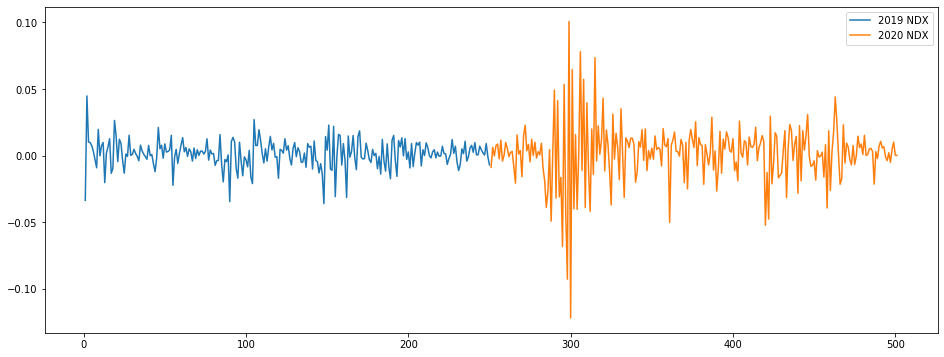

In [20]:
plt.figure(figsize=(16,6))
plt.plot(daily_return2019['NDX'], label='2019 NDX')
plt.plot(daily_return2020.set_index(daily_return2020['NDX'].index + 250)['NDX'], label = '2020 NDX')
plt.legend()

## Generate Similarity Matrix using 2019 daily return data

In [21]:
# similarity matrix - p
p2019 = generateSimilarityMatrix(daily_return2019)

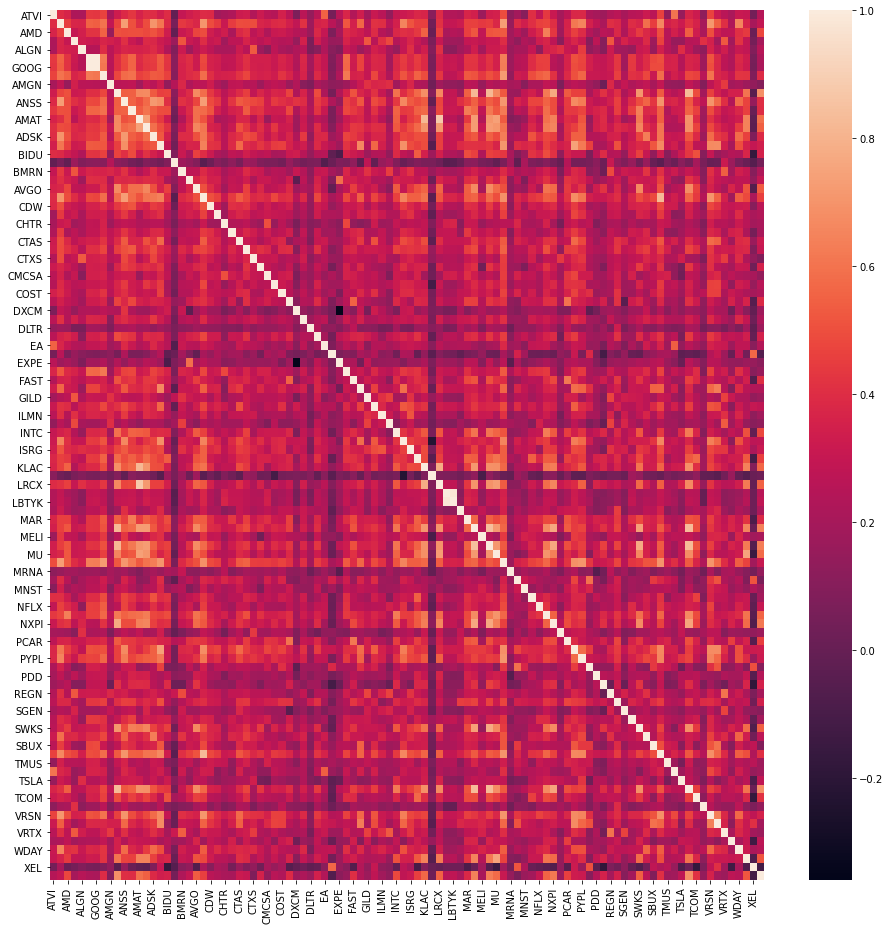

In [22]:
plt.figure(figsize=(16,16))
sns.heatmap(p2019)
plt.show()

## Find top `m` fund stocks `(m = 5)`

In [23]:
# Top 5 stocks
fund_stocks = generateTopStocks(p2019, m=5)
fund_stocks

Academic license - for non-commercial use only - expires 2022-11-04
Using license file C:\Users\mehen\gurobi.lic


Index(['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL'], dtype='object')

## Calculating Porfolio weights

In [24]:
fund_weights = calculatePortfolioWeights(daily_return=daily_return2019, fund_stocks=fund_stocks)
fund_weights

array([0.04886175, 0.21038806, 0.58035198, 0.07119022, 0.089208  ])

## Test 2020 index data

In [25]:
future_returns = calculateFutureReturn(daily_return=daily_return2020, fund_stocks=fund_stocks, fund_weights=fund_weights)
future_returns

1.1124373455076464

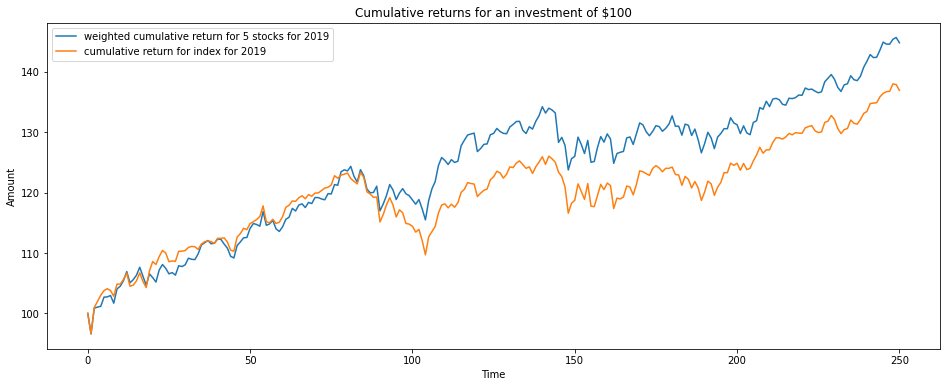

In [26]:
fund_stocks_cum_return, idx_cum_return = dailyCumulativeReturn(daily_return2019, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
plt.figure(figsize=(16,6))
plt.plot(fund_stocks_cum_return, label = 'weighted cumulative return for 5 stocks for 2019')
plt.plot(idx_cum_return, label = 'cumulative return for index for 2019')
plt.legend()
plt.title('Cumulative returns for an investment of $100')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

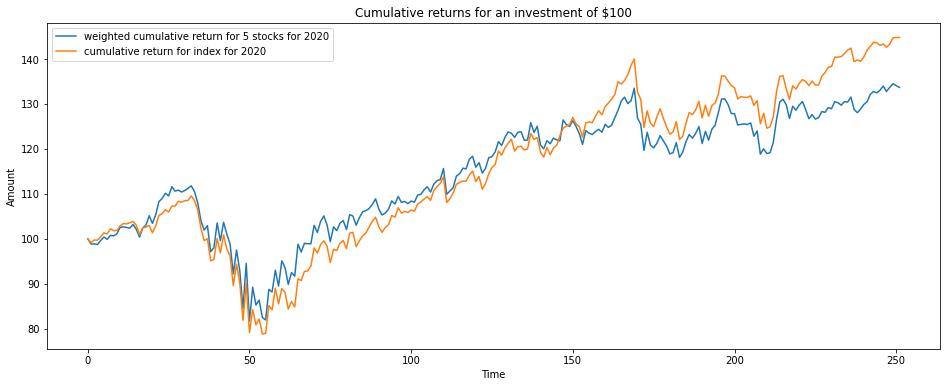

In [27]:
fund_stocks_cum_return, idx_cum_return = dailyCumulativeReturn(daily_return2020, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
plt.figure(figsize=(16,6))
plt.plot(fund_stocks_cum_return, label = 'weighted cumulative return for 5 stocks for 2020')
plt.plot(idx_cum_return, label = 'cumulative return for index for 2020')
plt.legend()
plt.title('Cumulative returns for an investment of $100')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

In [28]:
returns_list2020 = []
returns_list2019 = []
cum_return_2019 = []
cum_return_2020 = []
m_list = []
for i in range(10, 101, 10):
    fund_stocks = generateTopStocks(p2019, m=i)
    fund_weights = calculatePortfolioWeights(daily_return=daily_return2019, fund_stocks=fund_stocks)
    future_returns = calculateFutureReturn(daily_return=daily_return2020, fund_stocks=fund_stocks, fund_weights=fund_weights)
    fund_stocks_cum_return, _ = dailyCumulativeReturn(daily_return2020, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
    
    m_list.append(i)
    returns_list2020.append(future_returns)
    cum_return_2020.append(fund_stocks_cum_return.iloc[-1])
    
    fund_stocks = generateTopStocks(p2019, m=i)
    fund_weights = calculatePortfolioWeights(daily_return=daily_return2019, fund_stocks=fund_stocks)
    future_returns = calculateFutureReturn(daily_return=daily_return2019, fund_stocks=fund_stocks, fund_weights=fund_weights)
    fund_stocks_cum_return, _ = dailyCumulativeReturn(daily_return2019, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
    
    cum_return_2019.append(fund_stocks_cum_return.iloc[-1])
    returns_list2019.append(future_returns)

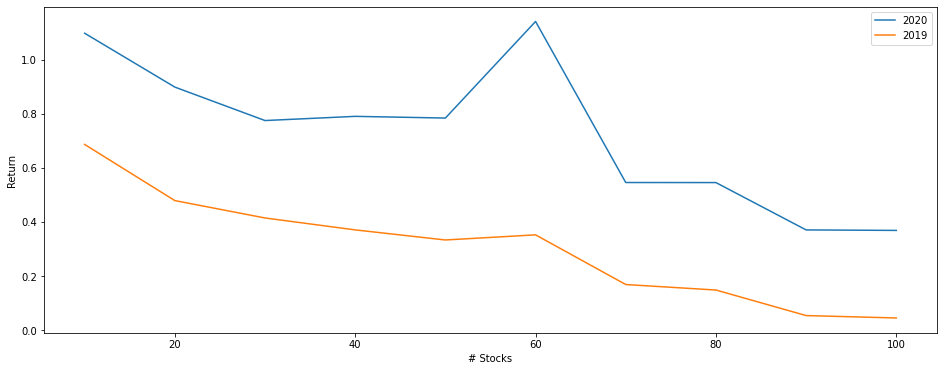

In [29]:
plt.figure(figsize = (16,6))
plt.plot(m_list, returns_list2020, label = '2020')
plt.plot(m_list, returns_list2019, label = '2019')
plt.legend()
plt.xlabel("# Stocks")
plt.ylabel("Return")
plt.show()

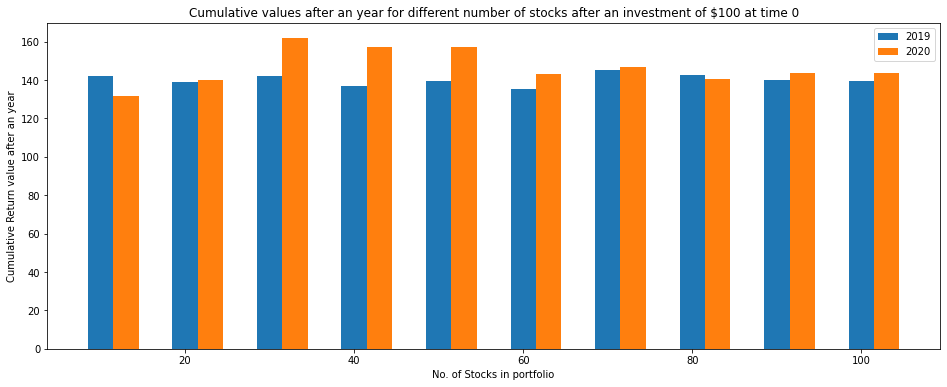

In [30]:
width = 3
plt.figure(figsize = (16,6))
plt.bar(np.array(m_list), cum_return_2019, width, label = '2019')
plt.bar(np.array(m_list)+width, cum_return_2020, width, label = '2020')
plt.legend()
plt.xlabel('No. of Stocks in portfolio')
plt.ylabel('Cumulative Return value after an year')
plt.title('Cumulative values after an year for different number of stocks after an investment of $100 at time 0')
plt.show()

In [31]:
print("For 2019, ", end="")
print((pd.Series(cum_return_2019).idxmax()+1)*10, "stocks required to reach the maximum cumulative value of", max(cum_return_2019))
print("For 2020, ", end="")
print((pd.Series(cum_return_2020).idxmax()+1)*10, "stocks required to reach the maximum cumulative value of", max(cum_return_2020))

For 2019, 70 stocks required to reach the maximum cumulative value of 145.38390347195994
For 2020, 30 stocks required to reach the maximum cumulative value of 161.82580560950086


## Is this graph useful ?

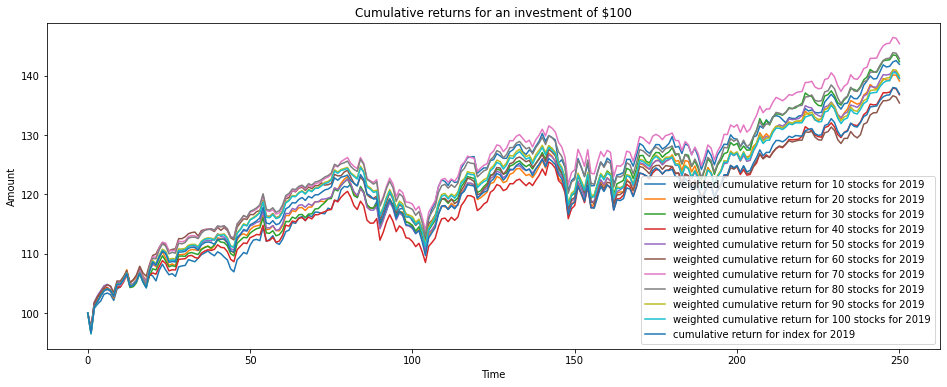

In [32]:
plt.figure(figsize=(16,6))
returns_list2020 = []
returns_list2019 = []
m_list = []

for m in range(10, 101, 10):
    fund_stocks = generateTopStocks(p2019, m=m)
    fund_weights = calculatePortfolioWeights(daily_return=daily_return2019, fund_stocks=fund_stocks)
    fund_stocks_cum_return, idx_cum_return = dailyCumulativeReturn(daily_return2019, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
    plt.plot(fund_stocks_cum_return, label = 'weighted cumulative return for '+ str(m) +' stocks for 2019')
    
plt.plot(idx_cum_return, label = 'cumulative return for index for 2019')
plt.legend()
plt.title('Cumulative returns for an investment of $100')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.show()

## Weight Selection via MIP

In [33]:
def calculatePortfolioWeightsMIP(daily_return, fund_stocks, m, index_col='NDX', M=1, time_limit=3600):
    
    # Objective
    # no. of days, no. of index stocks, no. fund_stocks
    n_index = (daily_return.shape[1]-1)
    obj = np.array([1]*len(daily_return) + [1]*n_index + [1]*len(fund_stocks)) 

    # Constraint Definition : A
    A = np.zeros((2*len(daily_return) + n_index + 1 + 1, len(obj)))

    # Sense definition
    sense = np.array(['>']*A.shape[0])

    # Constraint RHS : b
    b = np.array([0.0]*A.shape[0])

    # Updating A matrix
    row = 0

    # y > -(x-1)
    A[range(0, 2*len(daily_return), 2), 0:len(daily_return)] = np.identity(len(daily_return))
    A[range(0, 2*len(daily_return), 2), len(daily_return)+n_index:len(obj)] = np.array(daily_return[fund_stocks])
    b[range(0, 2*len(daily_return), 2)] = np.array(daily_return[index_col])

    # y > x - 1
    A[range(1, 2*len(daily_return), 2), 0:len(daily_return)] = np.identity(len(daily_return))
    A[range(1, 2*len(daily_return), 2), len(daily_return)+n_index:len(obj)] = -1*np.array(daily_return[fund_stocks])
    b[range(1, 2*len(daily_return), 2)] = -1*np.array(daily_return[index_col])
    row += 2*len(daily_return) 

    # at row : 500
    #  sum of y’s is equal to m
    A[row, len(daily_return) : len(daily_return)+n_index] = [1]*n_index
    sense[row] = '='
    b[row] = float(m)
    row+=1

    ## at row: 501
    ## w_i < y_i
#     print(len(daily_return)+n_index - len(obj))
    A[row:row+len(fund_stocks), len(daily_return)+n_index:len(obj)] = np.identity(len(fund_stocks))
    A[row:row+len(fund_stocks), len(daily_return):len(daily_return)+n_index] = -M * np.identity(n_index)
    sense[row:row+len(fund_stocks)] = '<'
    row+=n_index
    
    ## at row : 601
    ## summing all weights to 1
    A[-1, len(daily_return)+n_index:len(obj)] = 1
    sense[-1] = '='
    b[-1] = 1 
    
#     pd.DataFrame(A).to_csv('test.csv')
    vtype = ['C']*len(daily_return) + ['B']*n_index + ['C']*len(fund_stocks)
    objX = solve(obj, A, sense, b, min_max='minimize', vtype = vtype, time_limit = time_limit, show_output = False )

    return objX[-len(fund_stocks):]

In [34]:
fund_stocks_list = list(daily_return2019.columns[1:]) 
index_col_name = 'NDX'
M = 1
time_limit = 100

returns_list2020 = []
returns_list2019 = []
m_list = []

for m in range(10, 101, 10):
    fund_weights = calculatePortfolioWeightsMIP(daily_return=daily_return2019, fund_stocks=fund_stocks_list,
                                          m = m, index_col=index_col_name, M=M, time_limit=time_limit)
    
    pd.DataFrame(fund_weights).to_csv('fund_weights_'+str(m)+'.csv')
    future_returns = calculateFutureReturn(daily_return=daily_return2020, fund_stocks=fund_stocks, fund_weights=fund_weights)
    returns_list2020.append(future_returns)
    
    future_returns = calculateFutureReturn(daily_return=daily_return2019, fund_stocks=fund_stocks, fund_weights=fund_weights)
    returns_list2019.append(future_returns)
    m_list.append(m)

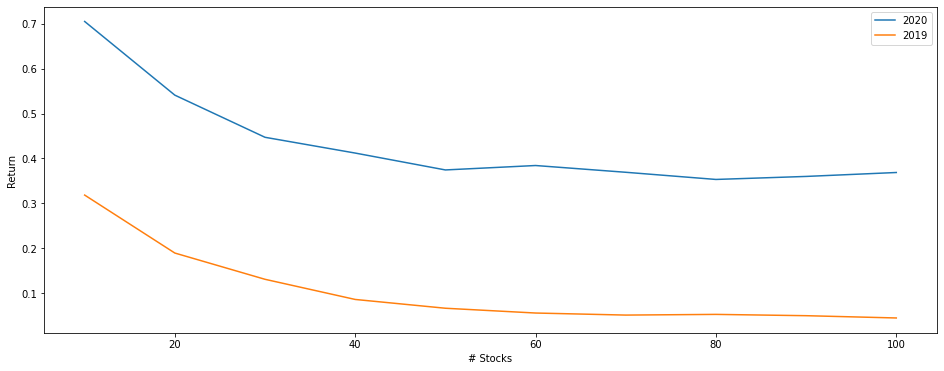

In [35]:
plt.figure(figsize = (16,6))
plt.plot(m_list, returns_list2020, label = '2020')
plt.plot(m_list, returns_list2019, label = '2019')
plt.legend()
plt.xlabel("# Stocks")
plt.ylabel("Return")
plt.show()

In [48]:
# weights_df = pd.DataFrame()
# for m in range(10, 101, 10):
#     filename = 'fund_weights_'+str(m)+'.csv'
#     weights = pd.read_csv(filename, index_col=0)
#     weights_df[m] = weights['0']

# Weights Calculated after 10 hours of run

In [49]:
calculated_weights = [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.36094029e-03,3.16645774e-03, 5.07467358e-03, 5.09652224e-03, 3.11873978e-03,5.55625364e-03, 4.22328959e-03],
       [0.00000000e+00, 0.00000000e+00, 2.66347114e-02, 3.01314199e-02, 2.24906913e-02, 1.78986179e-02, 1.79597759e-02, 1.80720067e-02, 1.56964084e-02, 1.71400493e-02],
       [0.00000000e+00, 0.00000000e+00, 6.70987822e-03, 3.35690897e-03, 7.49100633e-03, 5.34511617e-03, 2.51899939e-03, 4.94338426e-03,
2.72311442e-03, 4.03700187e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.34440634e-04, 2.44975218e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.94304147e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.04249183e-02, 8.50390099e-02,
        8.34258762e-02, 8.14401269e-02, 8.66816156e-02, 8.98301490e-02,
        3.73346090e-02, 5.68288393e-02],
       [9.37809991e-02, 9.16837996e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.26565266e-03, 0.00000000e+00, 0.00000000e+00,
        4.73072025e-02, 2.97166204e-02],
       [1.77006622e-01, 8.35000811e-02, 9.02930071e-02, 9.29230236e-02,
        9.80808979e-02, 9.71707267e-02, 9.57444207e-02, 9.39379624e-02,
        9.69543579e-02, 9.56134145e-02],
       [0.00000000e+00, 4.27953490e-02, 1.81075691e-02, 1.78416296e-02,
        1.60097138e-02, 1.43057976e-02, 1.46225366e-02, 1.80643744e-02,
        1.15851102e-02, 1.36372497e-02],
       [7.75669144e-02, 0.00000000e+00, 1.97207578e-02, 0.00000000e+00,
        0.00000000e+00, 1.08420217e-19, 0.00000000e+00, 3.28403280e-03,
        3.92524564e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.51934910e-03,
        0.00000000e+00, 0.00000000e+00],
       [1.33454621e-01, 1.08922609e-01, 1.19695951e-01, 1.08815130e-01,
        1.11070902e-01, 1.01528387e-01, 1.04145577e-01, 1.01659810e-01,
        1.01832029e-01, 1.02011397e-01],
       [0.00000000e+00, 2.88185676e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.21002477e-03,
        9.28053418e-03, 3.55226480e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.87363101e-04,
        0.00000000e+00, 1.35311414e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.77079451e-03, 9.53221696e-03, 3.52803716e-03, 7.12351856e-03,
        4.11323185e-03, 3.92298038e-03],
       [0.00000000e+00, 0.00000000e+00, 2.55471492e-02, 3.02256778e-02,
        2.12055745e-02, 1.60632742e-02, 1.66397787e-02, 0.00000000e+00,
        1.95975492e-02, 1.47585757e-02],
       [0.00000000e+00, 2.30652084e-02, 7.29027848e-03, 8.03033744e-03,
        9.20162550e-03, 5.36516269e-03, 5.19477714e-03, 6.66656006e-03,
        4.70466426e-03, 5.12995688e-03],
       [0.00000000e+00, 0.00000000e+00, 8.75441677e-03, 8.61735406e-03,
        7.13226133e-03, 5.93573928e-03, 6.87913725e-03, 7.47993476e-03,
        6.64186874e-03, 6.65961040e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.50702094e-03, 3.96161154e-03],
       [0.00000000e+00, 1.92236812e-02, 2.12416821e-02, 1.44004562e-02,
        1.36411310e-02, 1.33531171e-02, 9.63359203e-03, 1.20099665e-02,
        1.14683256e-02, 1.13472897e-02],
       [0.00000000e+00, 0.00000000e+00, 1.83197939e-02, 1.68755184e-02,
        1.34136463e-02, 1.18642579e-02, 1.49200807e-02, 9.72492809e-03,
        1.52846079e-02, 1.28711993e-02],
       [0.00000000e+00, 0.00000000e+00, 1.03404059e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.20132198e-06, 3.81846606e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [7.59807172e-02, 0.00000000e+00, 0.00000000e+00, 1.40622920e-02,
        9.63748482e-03, 4.19361467e-03, 1.02954055e-02, 7.11022466e-03,
        1.11327541e-02, 7.94373322e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.23310699e-03,
        0.00000000e+00, 1.63648394e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.03632017e-03,
        4.09261107e-03, 2.30747386e-03],
       [0.00000000e+00, 4.69922425e-02, 3.27278760e-02, 3.16691243e-02,
        2.77826005e-02, 2.37724863e-02, 2.79034024e-02, 2.67975327e-02,
        2.72267314e-02, 2.72108580e-02],
       [5.93113639e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.67762983e-03,
        3.94662705e-03, 2.54003100e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.99336800e-03, 3.34579548e-03, 7.10252789e-03,
        3.27970916e-03, 3.69731689e-03],
       [0.00000000e+00, 3.02380377e-02, 3.54806972e-02, 2.55350048e-02,
        2.85493646e-02, 2.69324653e-02, 2.35259985e-02, 2.56850849e-02,
        2.47283059e-02, 2.32220945e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.05789141e-02, 1.89046508e-02,
        2.21244234e-02, 1.54516512e-02, 1.23866089e-02, 1.96839280e-02,
        1.64037416e-02, 1.13141716e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.56062961e-02,
        1.44673956e-02, 1.19870551e-02, 7.56949159e-03, 1.14086828e-02,
        1.21822421e-02, 1.03248442e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.45274560e-03, 0.00000000e+00,
        3.92126115e-04, 1.42872473e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.01535024e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.03320045e-03, 7.01205770e-03, 6.47650376e-03, 7.46702630e-03,
        6.03912700e-03, 6.82688794e-03],
       [0.00000000e+00, 2.09370902e-02, 0.00000000e+00, 1.19430994e-02,
        0.00000000e+00, 9.04475055e-03, 6.69383590e-03, 5.73245051e-03,
        1.13445697e-02, 5.05738584e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 5.19177095e-03, 3.28676258e-03,
        3.19788984e-03, 2.38858877e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.72475394e-03, 0.00000000e+00,
        7.61194027e-03, 4.07095744e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.96945097e-03, 0.00000000e+00, 3.41544072e-03, 1.81957714e-03,
        1.12306908e-03, 2.74718989e-03],
       [0.00000000e+00, 5.53342440e-02, 5.43906186e-02, 5.25056535e-02,
        5.30522082e-02, 5.01514780e-02, 4.99304865e-02, 4.58269681e-02,
        4.82403431e-02, 4.73242246e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.25955276e-03, 2.27376787e-03,
        2.55489378e-03, 1.86532756e-03],
       [6.12770042e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.93964249e-03, 0.00000000e+00,
        3.79958212e-04, 3.69268488e-03],
       [6.70619555e-02, 3.73777254e-02, 3.96426187e-02, 2.45259393e-02,
        1.46686012e-02, 1.33073190e-02, 1.60188523e-02, 1.46566450e-02,
        1.20496944e-02, 1.21101340e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.25303279e-03,
        8.85499888e-04, 7.17705638e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.41236972e-02,
        6.76366378e-03, 5.85428497e-03, 6.86264822e-03, 4.82693601e-03,
        7.12984574e-03, 5.38441503e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.82611841e-03, 0.00000000e+00, 3.40921954e-03,
        2.04134549e-03, 1.70130752e-03],
       [6.41713452e-02, 3.89720396e-02, 3.63454938e-02, 3.36937015e-02,
        3.17504051e-02, 3.74647937e-02, 3.15969955e-02, 3.34668184e-02,
        2.88272277e-02, 3.24019804e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.95737427e-03,
        1.51389831e-02, 9.82589466e-03, 8.26407586e-03, 9.14603282e-03,
        7.10236162e-03, 7.66876277e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.11763909e-02, 1.53141420e-02, 1.12010714e-02, 1.11230452e-02,
        1.10401846e-02, 1.09998039e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.88130641e-03, 0.00000000e+00, 4.59344475e-03,
        4.04473818e-03, 5.16878026e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.89010469e-03, 9.13314546e-03, 2.14941186e-03,
        3.63021486e-03, 5.19550394e-03],
       [0.00000000e+00, 0.00000000e+00, 1.48408544e-02, 0.00000000e+00,
        7.57982758e-03, 7.56273476e-03, 6.32543271e-03, 6.46123696e-03,
        4.70397934e-03, 6.50810168e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.53244383e-03, 7.06457747e-03, 0.00000000e+00, 3.90666262e-04,
        0.00000000e+00, 2.48127070e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.95355492e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.65896103e-03, 3.21479567e-03,
        2.51076158e-03, 2.94570723e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.76171555e-03, 2.14522076e-04, 3.04119066e-03,
        2.05662992e-03, 2.36788692e-03],
       [0.00000000e+00, 0.00000000e+00, 1.13610062e-02, 0.00000000e+00,
        0.00000000e+00, 1.00086370e-02, 8.31006835e-03, 8.20696177e-03,
        1.33571897e-02, 9.07178979e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.65767961e-02,
        1.00713386e-02, 1.43878205e-02, 1.88874701e-02, 1.17851661e-02,
        7.41728063e-03, 1.05251224e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.89134292e-03, 0.00000000e+00, 2.55034428e-03, 2.60175975e-03,
        2.59615323e-03, 2.11917017e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.86884379e-03, 3.24307406e-03, 2.33807707e-03,
        6.07544806e-03, 4.21771472e-03],
       [0.00000000e+00, 0.00000000e+00, 1.23138836e-02, 1.43512720e-02,
        1.07671931e-02, 4.47008959e-03, 8.73519069e-03, 7.40138987e-03,
        4.67625059e-03, 5.32832419e-03],
       [1.90388458e-01, 1.78019955e-01, 1.17981538e-01, 1.07285168e-01,
        1.01259420e-01, 1.02547880e-01, 1.03498448e-01, 1.05234516e-01,
        1.02205448e-01, 1.01356338e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.50975024e-03, 1.49198435e-04,
        2.16998423e-05, 3.89609332e-04],
       [0.00000000e+00, 5.66413809e-02, 0.00000000e+00, 2.83744061e-02,
        1.99732644e-02, 1.61035091e-02, 1.88052691e-02, 1.91049848e-02,
        2.07083542e-02, 1.39286645e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.72414975e-03, 4.27650833e-03,
        1.82660827e-03, 1.22997509e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 4.97743606e-03, 2.50470669e-03,
        2.07122517e-03, 3.12327647e-03],
       [0.00000000e+00, 1.61765013e-02, 2.52445502e-02, 1.85292593e-02,
        2.08865941e-02, 1.92770629e-02, 1.68349608e-02, 1.39840503e-02,
        1.78114007e-02, 1.62717626e-02],
       [0.00000000e+00, 0.00000000e+00, 6.89429620e-03, 6.78357904e-03,
        6.57016665e-03, 8.85410830e-03, 8.16972998e-03, 8.90388339e-03,
        1.28336684e-02, 9.57589491e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.83012254e-03, 0.00000000e+00, 0.00000000e+00, 3.33369554e-03,
        4.70941324e-03, 2.31532213e-03],
       [0.00000000e+00, 0.00000000e+00, 2.07710175e-02, 1.22364014e-02,
        1.13175318e-02, 0.00000000e+00, 5.31055777e-03, 4.70806285e-03,
        7.29859830e-03, 3.67322007e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.38137814e-03, 5.85394922e-04,
        0.00000000e+00, 4.09483055e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.72081374e-03, 1.63608727e-03, 7.94005132e-03,
        3.77794346e-03, 6.41250280e-03],
       [0.00000000e+00, 5.31093864e-02, 3.56739811e-02, 2.87399193e-02,
        2.43885072e-02, 1.98057326e-02, 2.12505581e-02, 2.18502355e-02,
        1.81066179e-02, 2.03809198e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.19339355e-02, 1.55618237e-02, 0.00000000e+00, 0.00000000e+00,
        1.12385442e-02, 1.58707164e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.23896105e-04,
        0.00000000e+00, 2.13994977e-05],
       [0.00000000e+00, 0.00000000e+00, 7.86105257e-03, 8.09733541e-03,
        1.25774822e-02, 1.33866372e-02, 1.16259162e-02, 1.08992004e-02,
        1.01801168e-02, 1.11390250e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.70663198e-03, 7.76179095e-03, 8.27632622e-03, 6.08952561e-03,
        9.44951209e-03, 5.59514458e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.09028543e-03, 0.00000000e+00,
        0.00000000e+00, 4.57532067e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.37763745e-04,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.03990614e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.10657231e-03, 7.02316341e-03, 8.57193403e-03,
        1.02527988e-02, 6.04287276e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.37801718e-02,
        1.57094390e-02, 1.25671137e-02, 8.18007982e-03, 1.12946612e-02,
        4.60185450e-03, 5.01070109e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.57666821e-03, 9.66445873e-03,
        4.23743143e-03, 5.11468996e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.12046124e-02,
        6.66371180e-03, 1.14584472e-02, 9.36816731e-03, 1.03055316e-02,
        1.04308687e-02, 1.03224805e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.00919546e-03, 0.00000000e+00, 0.00000000e+00, 4.04868885e-03,
        0.00000000e+00, 2.14717759e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.26147455e-03,
        4.04023904e-03, 5.57125921e-03, 7.34274091e-03, 6.95619905e-03,
        7.99224528e-03, 6.51116005e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.03954690e-02,
        1.27740339e-02, 1.07078155e-02, 9.36352444e-03, 9.07678856e-03,
        1.45081038e-02, 1.26172288e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.32792515e-04, 0.00000000e+00,
        0.00000000e+00, 4.62870238e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.61902764e-03,
        4.69619046e-03, 4.61689891e-03, 5.30486283e-03, 4.61335019e-03,
        3.70249139e-03, 3.83324661e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.06060629e-03, 6.28763984e-03,
        7.90823213e-03, 6.18102388e-03],
       [0.00000000e+00, 0.00000000e+00, 4.04202925e-02, 0.00000000e+00,
        0.00000000e+00, 1.30162589e-02, 1.17215147e-02, 0.00000000e+00,
        2.02854685e-03, 6.63414936e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.10551441e-02,
        1.19098411e-02, 7.67938588e-03, 7.03029169e-03, 5.80985287e-03,
        4.66221860e-03, 8.83235296e-03],
       [0.00000000e+00, 1.44765350e-02, 0.00000000e+00, 9.69470995e-03,
        9.83965156e-03, 8.58559158e-03, 8.07136727e-03, 7.93515604e-03,
        0.00000000e+00, 9.13101948e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 4.42564866e-03, 1.61589503e-03, 0.00000000e+00,
        2.31105191e-03, 2.55579745e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.79772540e-03,
        0.00000000e+00, 3.66190355e-03],
       [0.00000000e+00, 3.33165053e-02, 1.43907900e-02, 8.87101485e-03,
        7.85714426e-03, 4.17887751e-03, 6.83933467e-03, 6.27281456e-03,
        4.38597107e-03, 5.44226059e-03]]

In [50]:
weights_df = pd.DataFrame(calculated_weights, columns = range(10,101,10) )

In [51]:
cum_return_2019 = []
cum_return_2020 = []
m_list = []
for i in range(10, 101, 10):
    fund_weights = np.array(weights_df[i])
    fund_stocks = list(daily_return2019.columns[1:])
    fund_stocks_cum_return, _ = dailyCumulativeReturn(daily_return2020, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
    cum_return_2020.append(fund_stocks_cum_return.iloc[-1])
    
    fund_stocks_cum_return, _ = dailyCumulativeReturn(daily_return2019, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
    cum_return_2019.append(fund_stocks_cum_return.iloc[-1])
    
    m_list.append(i)

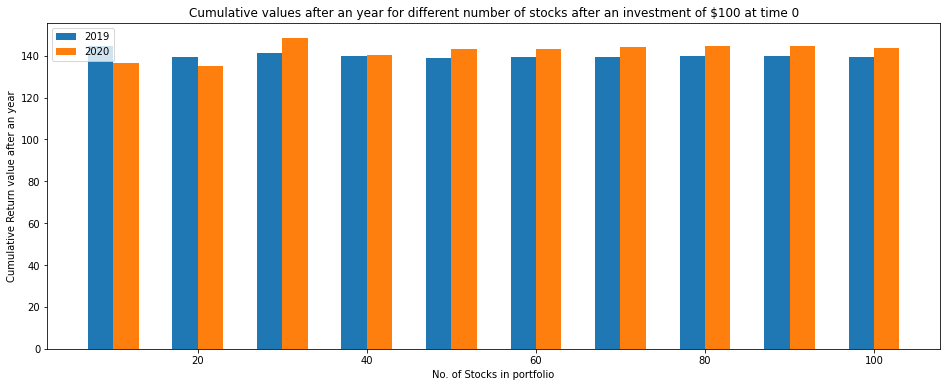

In [240]:
width = 3
plt.figure(figsize = (16,6))
plt.bar(np.array(m_list)-width/2, cum_return_2019, width, label = '2019')
plt.bar(np.array(m_list)+width/2, cum_return_2020, width, label = '2020')
plt.legend()
plt.xlabel('No. of Stocks in portfolio')
plt.ylabel('Cumulative Return value after an year')
plt.title('Cumulative values after an year for different number of stocks after an investment of $100 at time 0')
plt.show()

In [228]:
print("For 2019, ", end="")
print((pd.Series(cum_return_2019).idxmax()+1)*10, "stocks required to reach the maximum cumulative value of", max(cum_return_2019))
print("For 2020, ", end="")
print((pd.Series(cum_return_2020).idxmax()+1)*10, "stocks required to reach the maximum cumulative value of", max(cum_return_2020))

For 2019, 10 stocks required to reach the maximum cumulative value of 144.41877920282943
For 2020, 30 stocks required to reach the maximum cumulative value of 148.3631458374025


# Comparison between 2 methods

# 2019

In [236]:
cum_return_new = []
cum_return_old = []
m_list = []
for i in range(10, 101, 10):
    fund_weights = np.array(weights_df[i])
    fund_stocks = list(daily_return2019.columns[1:])
    fund_stocks_cum_return, _ = dailyCumulativeReturn(daily_return2019, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
    cum_return_new.append(fund_stocks_cum_return.iloc[-1])
    
    fund_stocks = generateTopStocks(p2019, m=i)
    fund_weights = calculatePortfolioWeights(daily_return=daily_return2019, fund_stocks=fund_stocks)
    fund_stocks_cum_return, _ = dailyCumulativeReturn(daily_return2019, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
    cum_return_old.append(fund_stocks_cum_return.iloc[-1])
    
    m_list.append(i)

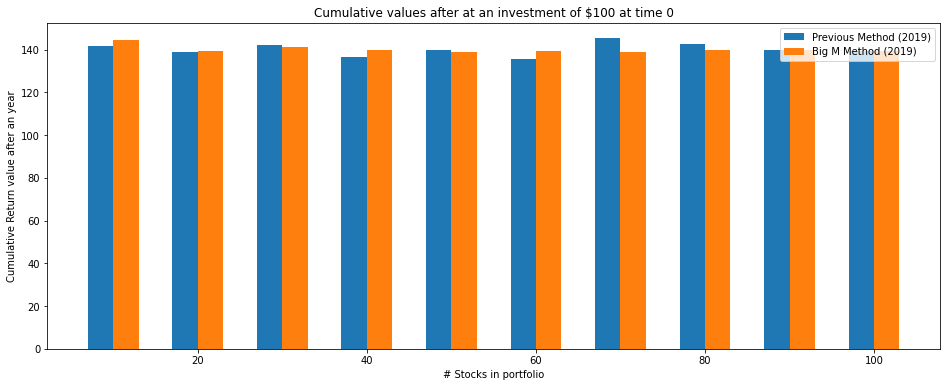

In [238]:
width = 3
plt.figure(figsize = (16,6))
plt.bar(np.array(m_list)-width/2, cum_return_old, width, label = 'Previous Method (2019)')
plt.bar(np.array(m_list)+width/2, cum_return_new, width, label = 'Big M Method (2019)')
plt.legend()
plt.xlabel('# Stocks in portfolio')
plt.ylabel('Cumulative Return value after an year')
plt.title('Cumulative values after at an investment of $100 at time 0')
plt.show()

## Deviation in the returns : MAPE

In [250]:
mape_2019 = np.sum(np.abs((np.array(cum_return_old) - np.array(cum_return_new))/np.array(cum_return_old))) / len(cum_return_old)
print("Mean Absolute Percentage Error between 2 methods", mape_2019*100)

Mean Absolute Percentage Error between 2 methods 1.480809644447611


# 2020

In [251]:
cum_return_new = []
cum_return_old = []
m_list = []
for i in range(10, 101, 10):
    fund_weights = np.array(weights_df[i])
    fund_stocks = list(daily_return2019.columns[1:])
    fund_stocks_cum_return, _ = dailyCumulativeReturn(daily_return2020, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
    cum_return_new.append(fund_stocks_cum_return.iloc[-1])
    
    fund_stocks = generateTopStocks(p2019, m=i)
    fund_weights = calculatePortfolioWeights(daily_return=daily_return2019, fund_stocks=fund_stocks)
    fund_stocks_cum_return, _ = dailyCumulativeReturn(daily_return2020, fund_stocks=fund_stocks, fund_weights=fund_weights, index_col='NDX')
    cum_return_old.append(fund_stocks_cum_return.iloc[-1])
    
    m_list.append(i)

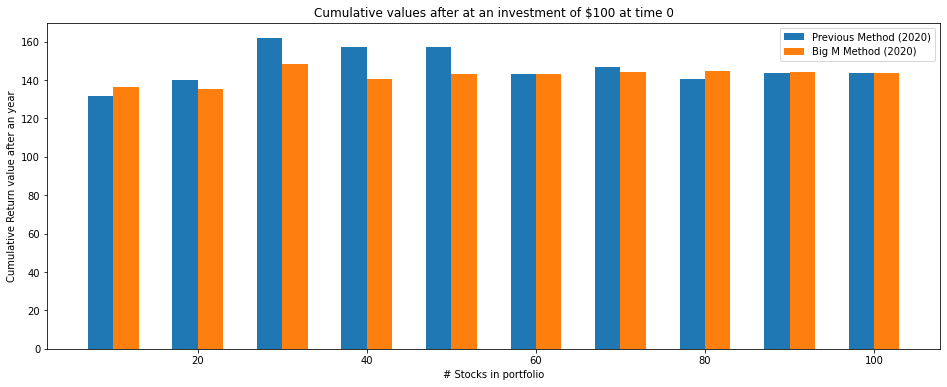

In [252]:
width = 3
plt.figure(figsize = (16,6))
plt.bar(np.array(m_list)-width/2, cum_return_old, width, label = 'Previous Method (2020)')
plt.bar(np.array(m_list)+width/2, cum_return_new, width, label = 'Big M Method (2020)')
plt.legend()
plt.xlabel('# Stocks in portfolio')
plt.ylabel('Cumulative Return value after an year')
plt.title('Cumulative values after at an investment of $100 at time 0')
plt.show()

In [253]:
mape_2020 = np.sum(np.abs((np.array(cum_return_old) - np.array(cum_return_new))/np.array(cum_return_old))) / len(cum_return_old)
print("Mean Absolute Percentage Error between 2 methods", mape_2020*100)

Mean Absolute Percentage Error between 2 methods 4.0194595479006185
